In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack

In [3]:
from maddeb.utils import listdir_fullpath, get_data_dir_path

In [4]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

## load the saved results

In [5]:
density_level = "high"

In [6]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/" + density_level + "_density"
run_name = "kl1" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [7]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

blended_plot_color = sns.color_palette()[4]
isolated_plot_color = sns.color_palette()[1]


scarlet_plot_ls = "-"
madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r'\texttt{scarlet}'
madness_plot_label = r'\texttt{MADNESS}'
debvader_plot_label = r'\texttt{VAE-deblender}'

In [8]:
madness_results=[]
debvader_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    debvader_results.append(pd.read_pickle(os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")))
    scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [9]:
mask=madness_results["r_contamination"].values<5

madness_results=madness_results[mask]
scarlet_results=scarlet_results[mask]
actual_photometry=actual_photometry[mask]
blended_photometry=blended_photometry[mask]
debvader_results=debvader_results[mask]

In [10]:
madness_results.columns

Index(['u_cosd', 'u_ssim', 'u_blendedness', 'g_cosd', 'g_ssim',
       'g_blendedness', 'r_cosd', 'r_ssim', 'r_blendedness', 'i_cosd',
       'i_ssim', 'i_blendedness', 'z_cosd', 'z_ssim', 'z_blendedness',
       'y_cosd', 'y_ssim', 'y_blendedness', 'galaxy_num', 'size', 'field_num',
       'file_num', 'r_band_snr', 'ref_mag', 'u_ab', 'g_ab', 'r_ab', 'i_ab',
       'z_ab', 'y_ab', 'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags',
       'g_phot_flux', 'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux',
       'r_phot_fluxerrs', 'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs',
       'i_phot_flags', 'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags',
       'y_phot_flux', 'y_phot_fluxerrs', 'y_phot_flags', 'r_contamination'],
      dtype='object')

In [11]:
# mask=madness_results['r_ab'].values<26
# mask=madness_results['r_ab'].values<26
# madness_results=madness_results[mask]
# scarlet_results=scarlet_results[mask]
# actual_photometry=actual_photometry[mask]
# blended_photometry=blended_photometry[mask]

In [12]:
import maddeb.boxplot
import matplotlib as mpl

# Perpare data for plots

In [13]:
import astropy.units as u
import galcheat

In [14]:
madness_results.columns

Index(['u_cosd', 'u_ssim', 'u_blendedness', 'g_cosd', 'g_ssim',
       'g_blendedness', 'r_cosd', 'r_ssim', 'r_blendedness', 'i_cosd',
       'i_ssim', 'i_blendedness', 'z_cosd', 'z_ssim', 'z_blendedness',
       'y_cosd', 'y_ssim', 'y_blendedness', 'galaxy_num', 'size', 'field_num',
       'file_num', 'r_band_snr', 'ref_mag', 'u_ab', 'g_ab', 'r_ab', 'i_ab',
       'z_ab', 'y_ab', 'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags',
       'g_phot_flux', 'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux',
       'r_phot_fluxerrs', 'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs',
       'i_phot_flags', 'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags',
       'y_phot_flux', 'y_phot_fluxerrs', 'y_phot_flags', 'r_contamination'],
      dtype='object')

In [15]:
survey = galcheat.helpers.get_survey("LSST")

for band in ["u", "g", "r", "i", "y", "z"]:

    z_point = survey.get_filter(band).zeropoint
    exp_time = survey.get_filter(band).full_exposure_time

    actual_phot_mag = actual_photometry[f"{band}_phot_flux"].values
    actual_photometry[f"{band}_phot_mag"] = ((actual_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value
    
    blended_phot_mag = blended_photometry[f"{band}_phot_flux"].values
    blended_photometry[f"{band}_phot_mag"] = ((blended_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value

    madness_phot_mag = madness_results[f"{band}_phot_flux"].values
    madness_results[f"{band}_phot_mag"] = ((madness_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point ).value
    
    scarlet_phot_mag = scarlet_results[f"{band}_phot_flux"].values
    scarlet_results[f"{band}_phot_mag"] = ((scarlet_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units

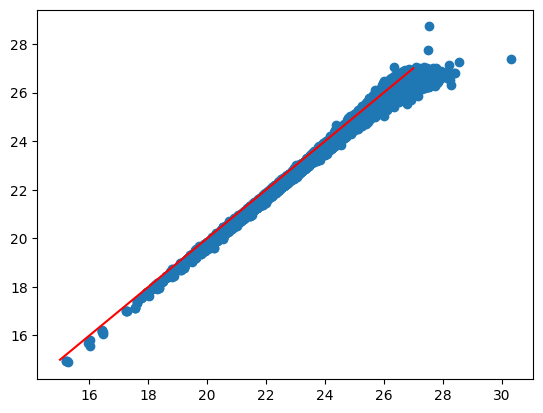

In [16]:
plt.scatter(actual_photometry["i_phot_mag"], madness_results["i_ab"])
plt.plot([15,27],[15,27], color="r")

In [17]:
color_bands="gr"

In [18]:
color_bands[0]

'g'

In [19]:
phot_color = actual_photometry[color_bands[0]+"_phot_mag"].values - actual_photometry[color_bands[1]+"_phot_mag"].values
true_color = madness_results[color_bands[0]+"_ab"].values - madness_results[color_bands[1] + "_ab"].values
blended_color = blended_photometry[color_bands[0]+"_phot_mag"].values - blended_photometry[color_bands[1]+"_phot_mag"].values

madness_results[color_bands+'_color'] = madness_results[color_bands[0]+"_phot_mag"] - madness_results[color_bands[1]+"_phot_mag"]
scarlet_results[color_bands+'_color'] = scarlet_results[color_bands[0]+"_phot_mag"] - scarlet_results[color_bands[1]+"_phot_mag"]

In [20]:
boxplot_color_df = {}

boxplot_color_df["snr"] = list(madness_results['r_band_snr'])
boxplot_color_df['r_blendedness'] = list(madness_results['r_blendedness'])
boxplot_color_df['r_contamination'] = list(madness_results['r_contamination'])
boxplot_color_df["type"] = ["madness"] * len(madness_results['size'])
boxplot_color_df[color_bands+'_color_err_phot'] = list(madness_results[color_bands+'_color'].values-phot_color)
boxplot_color_df[color_bands+'_color_err_true'] = list(madness_results[color_bands+'_color'].values-true_color)
boxplot_color_df[color_bands+'_phot'] = list(phot_color)
boxplot_color_df[color_bands+'_truth'] = list(true_color)

boxplot_color_df["snr"].extend(list(scarlet_results['r_band_snr']))
boxplot_color_df['r_blendedness'].extend(list(scarlet_results['r_blendedness']))
boxplot_color_df['r_contamination'].extend(list(madness_results['r_contamination']))
boxplot_color_df["type"].extend(["scarlet"] * len(scarlet_results['size']))
boxplot_color_df[color_bands+'_color_err_phot'].extend(list(scarlet_results[color_bands+'_color'].values-phot_color))
boxplot_color_df[color_bands+'_color_err_true'].extend(list(scarlet_results[color_bands+'_color'].values-true_color))
boxplot_color_df[color_bands+'_phot'].extend(list(phot_color))
boxplot_color_df[color_bands+'_truth'].extend(list(true_color))

boxplot_color_df["snr"].extend(list(scarlet_results['r_band_snr']))
boxplot_color_df['r_blendedness'].extend(list(scarlet_results['r_blendedness']))
boxplot_color_df['r_contamination'].extend(list(madness_results['r_contamination']))
boxplot_color_df["type"].extend(["blended"] * len(scarlet_results['size']))
boxplot_color_df[color_bands+'_color_err_phot'].extend(list(blended_color-phot_color))
boxplot_color_df[color_bands+'_color_err_true'].extend(list(blended_color-true_color))
boxplot_color_df[color_bands+'_phot'].extend(list(phot_color))
boxplot_color_df[color_bands+'_truth'].extend(list(true_color))
boxplot_color_df[color_bands+'_phot_bias'] = list(np.array(boxplot_color_df[color_bands+'_phot']) - np.array(boxplot_color_df[color_bands+'_truth']))

boxplot_color_df = pd.DataFrame(boxplot_color_df)

# Estimate bias in Aperture photometry colors

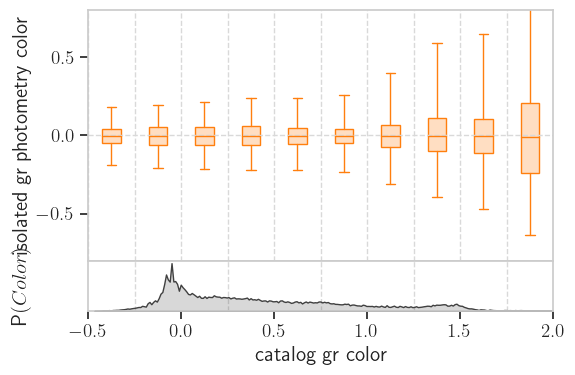

In [21]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df[boxplot_color_df["type"] == "madness"], 
    x = color_bands+"_truth", y = color_bands+"_phot_bias", z = "type",
    xlim = (-.5, 2),
    ylim = (-.8, .8), 
    x_scale = None,
    legend = [],
    x_label=f"catalog {color_bands} color", 
    y_label = f'isolated {color_bands} photometry color',
    y_label_hist=r'P$(Color)$',
    legend_remove = True,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color],#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "bias_color_box_plot.png"))

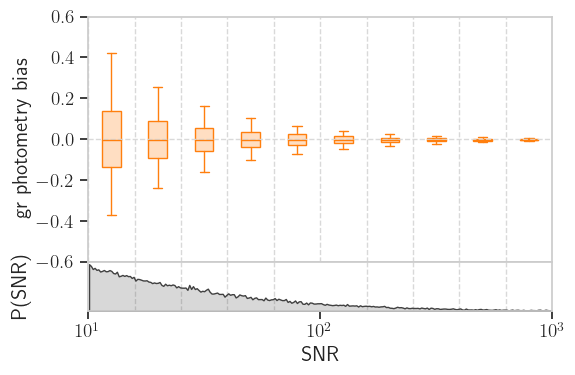

In [22]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df[boxplot_color_df["type"] == "madness"], 
    x = "snr", y = color_bands + "_phot_bias", z = "type",
    xlim = (10, 1000),
    ylim = (-.6, .6), 
    x_scale = "log",
    legend = ['madness', 'scarlet', 'blended'],
    x_label='SNR', 
    y_label = f'{color_bands} photometry bias',
    y_label_hist=r'P(SNR)',
    legend_remove = True,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color],#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "bias_color_box_plot.png"))

# Check the effect of blending

In [23]:
current_boxplot_color_df = {}
current_boxplot_color_df["snr"] = list(madness_results['r_band_snr'])
current_boxplot_color_df['r_blendedness'] = list(madness_results['r_blendedness'])
current_boxplot_color_df['r_contamination'] = list(madness_results['r_contamination'])
current_boxplot_color_df["type"] = ["Phot mesured"] * len(madness_results['size'])
current_boxplot_color_df[color_bands+'_color_err_true'] = phot_color-true_color
current_boxplot_color_df[color_bands+'_phot'] = list(phot_color)
current_boxplot_color_df[color_bands+'_truth'] = list(true_color)

current_boxplot_color_df = pd.DataFrame(current_boxplot_color_df)

In [24]:
current_boxplot_color_df = pd.concat([current_boxplot_color_df, boxplot_color_df], join='inner')

In [25]:
index = current_boxplot_color_df["type"].isin(['blended','Phot mesured'])

### The three bars in the plot below are 
- error color as measured by apperture photometry on isolated galaxies 
- error on deblended galaxies from madness
- error on deblended galaxies from scarlet

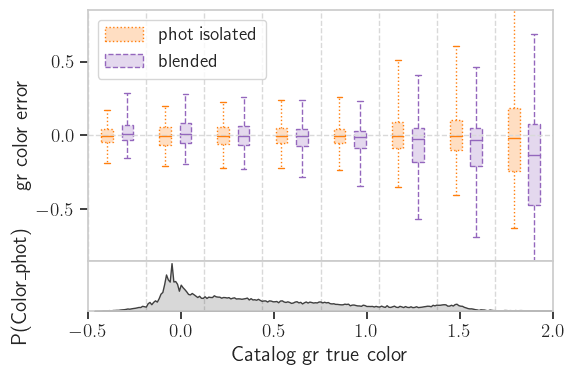

In [26]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = color_bands+"_truth", y = color_bands+'_color_err_true', z = "type",
    xlim = (-.5, 2),
    ylim = (-.85, 0.85),
    x_scale = None,
    legend = ['phot isolated', 'blended'],
    x_label=f'Catalog {color_bands} true color', 
    y_label = color_bands + ' color error',
    y_label_hist=r'P(Color_{phot})',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color, blended_plot_color],
    nbins = 8,
    ls = [isolated_plot_ls, blended_plot_ls]
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_bias_color_box_plot.png"))

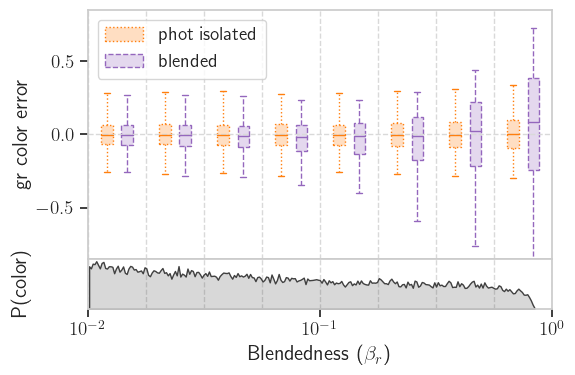

In [27]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = "r_blendedness", y = color_bands + '_color_err_true', z = "type",
    xlim = (1e-2, 1),
    ylim = (-.85, 0.85),
    x_scale = 'log',
    legend = ['phot isolated', 'blended'],
    x_label=r'Blendedness ($\beta_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(color)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color, blended_plot_color],#0.35,
    nbins = 8,
    ls = [isolated_plot_ls, blended_plot_ls],
    x_major_grid=True,
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_blendedness_color_box_plot.png"))

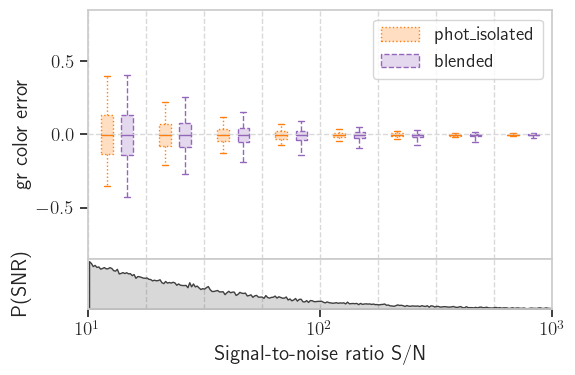

In [28]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = 'snr', y = color_bands + "_color_err_true", z = "type",
    xlim = (10, 1000),
    ylim = (-.85, 0.85), 
    x_scale = 'log',
    legend = ['phot_isolated', 'blended'],
    x_label='Signal-to-noise ratio S/N', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(SNR)',
    legend_remove = False,
    legend_location = "upper right",
    whis = [5,95],
    percents = [25,75],
    palette = [isolated_plot_color, blended_plot_color],#0.35,
    nbins = 8,
    ls = [isolated_plot_ls, blended_plot_ls],
    x_major_grid=True,
)

plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_snr_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_snr_color_box_plot.png"))

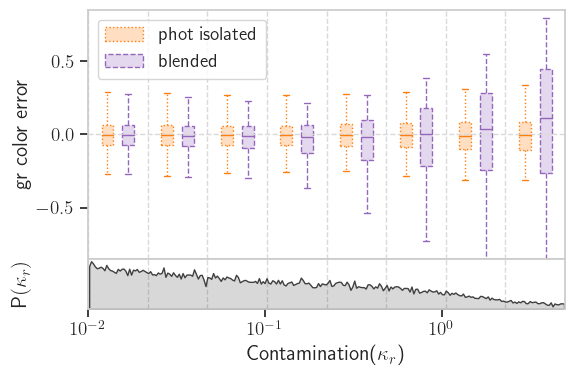

In [29]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = 'r_contamination', y = f"{color_bands}_color_err_true", z = "type",
    xlim = (1e-2, 5),
    ylim = (-.85, 0.85), 
    x_scale = 'log',
    legend = ['phot isolated', 'blended'],
    x_label=r'Contamination($\kappa_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P$(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color, blended_plot_color],#0.35,
    nbins = 8,
    ls = [isolated_plot_ls, blended_plot_ls]
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_contamination_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ib_contamination_color_box_plot.png"))

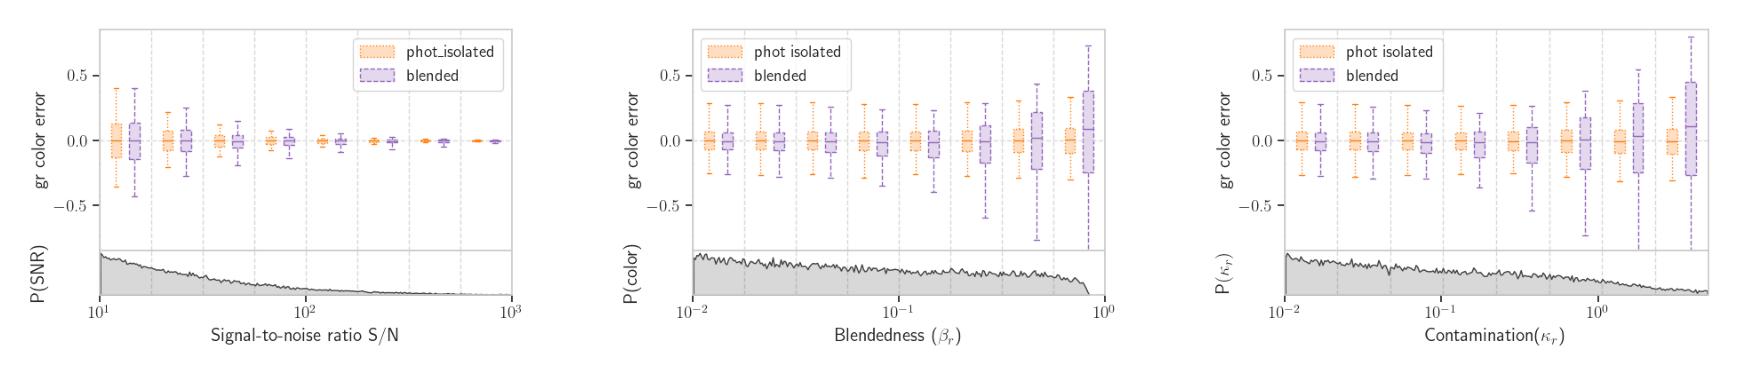

In [30]:
f, axarr = plt.subplots(1, 3, figsize=(18, 4))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ib_snr_color_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ib_blendedness_color_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ib_contamination_color_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", density_level + "_density", "blending_effect_" + density_level + "_density_color_boxplot_results.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join("results", density_level + "_density", "blending_effect_" + density_level + "_density_color_boxplot_results.png"))

plt.show()

# Errors from deblender against actual color from catalog

In [31]:
current_boxplot_color_df = {}
current_boxplot_color_df["snr"] = list(madness_results['r_band_snr'])
current_boxplot_color_df['r_blendedness'] = list(madness_results['r_blendedness'])
current_boxplot_color_df['r_contamination'] = list(madness_results['r_contamination'])
current_boxplot_color_df["type"] = ["Phot mesured"] * len(madness_results['size'])
current_boxplot_color_df[color_bands+'_color_err_true'] = phot_color-true_color
current_boxplot_color_df[color_bands+'_phot'] = list(phot_color)
current_boxplot_color_df[color_bands+'_truth'] = list(true_color)

current_boxplot_color_df = pd.DataFrame(current_boxplot_color_df)

In [32]:
current_boxplot_color_df = pd.concat([current_boxplot_color_df, boxplot_color_df], join='inner')

In [33]:
index = current_boxplot_color_df["type"].isin(['Phot mesured', 'madness', 'scarlet'])

### The three bars in the plot below are 
- error color as measured by apperture photometry on isolated galaxies 
- error on deblended galaxies from madness
- error on deblended galaxies from scarlet

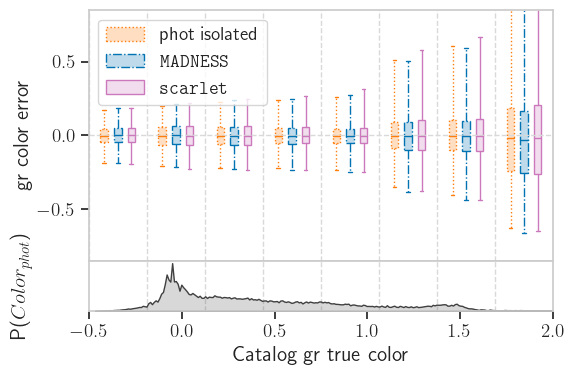

In [34]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = color_bands+"_truth", y = color_bands+'_color_err_true', z = "type",
    xlim = (-.5, 2),
    ylim = (-.85, 0.85),
    x_scale = None,
    legend = ['phot isolated', madness_plot_label, scarlet_plot_label],
    x_label=f'Catalog {color_bands} true color', 
    y_label = color_bands + ' color error',
    y_label_hist=r'P($Color_{phot}$)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color, madness_plot_color, scarlet_plot_color],
    nbins = 8,
    ls=[isolated_plot_ls, madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ims_bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp",  "ims_bias_color_box_plot.png"))

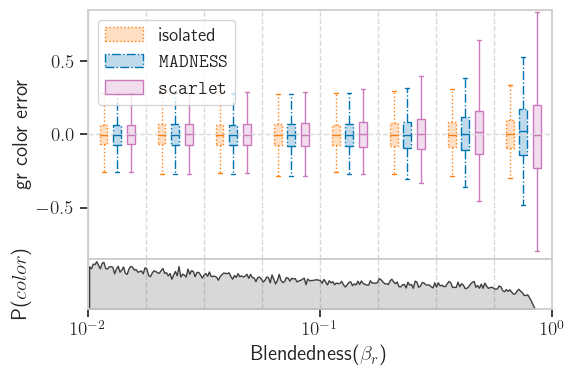

In [35]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = "r_blendedness", y = color_bands + '_color_err_true', z = "type",
    xlim = (1e-2, 1),
    ylim = (-.85, 0.85), 
    x_scale = 'log',
    legend = ['isolated', madness_plot_label, scarlet_plot_label],
    x_label=r'Blendedness($\beta_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P($color$)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[isolated_plot_ls, madness_plot_ls, scarlet_plot_ls],
    x_major_grid=True,
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ims_blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp",  "ims_blendedness_color_box_plot.png"))

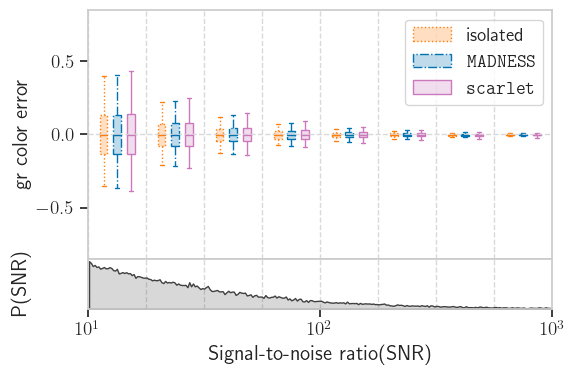

In [36]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = 'snr', y = color_bands + "_color_err_true", z = "type",
    xlim = (10, 1000),
    ylim = (-.85, 0.85),
    x_scale = 'log',
    legend = ['isolated', madness_plot_label, scarlet_plot_label],
    x_label='Signal-to-noise ratio(SNR)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(SNR)',
    legend_remove = False,
    legend_location = "upper right",
    whis = [5,95],
    percents = [25,75],
    palette = [isolated_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[isolated_plot_ls, madness_plot_ls, scarlet_plot_ls],
    x_major_grid=True,
)

plt.savefig(os.path.join("results", density_level + "_density", "temp", "ims_snr_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ims_snr_color_box_plot.png"))

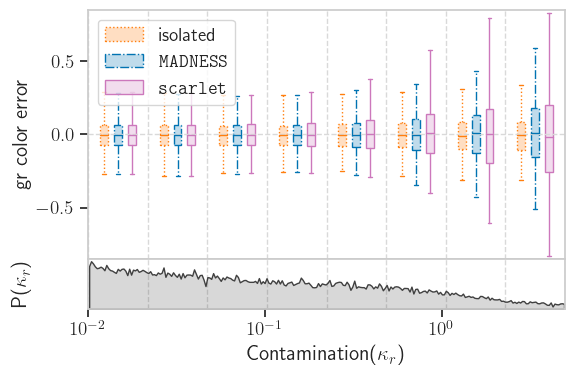

In [37]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    current_boxplot_color_df[index], 
    x = 'r_contamination', y = f"{color_bands}_color_err_true", z = "type",
    xlim = (1e-2, 5),
    ylim = (-.85, 0.85),
    x_scale = 'log',
    legend = ['isolated', madness_plot_label, scarlet_plot_label],
    x_label=r'Contamination($\kappa_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P($\kappa_r$)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[isolated_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[isolated_plot_ls, madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ims_contamination_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ims_contamination_color_box_plot.png"))

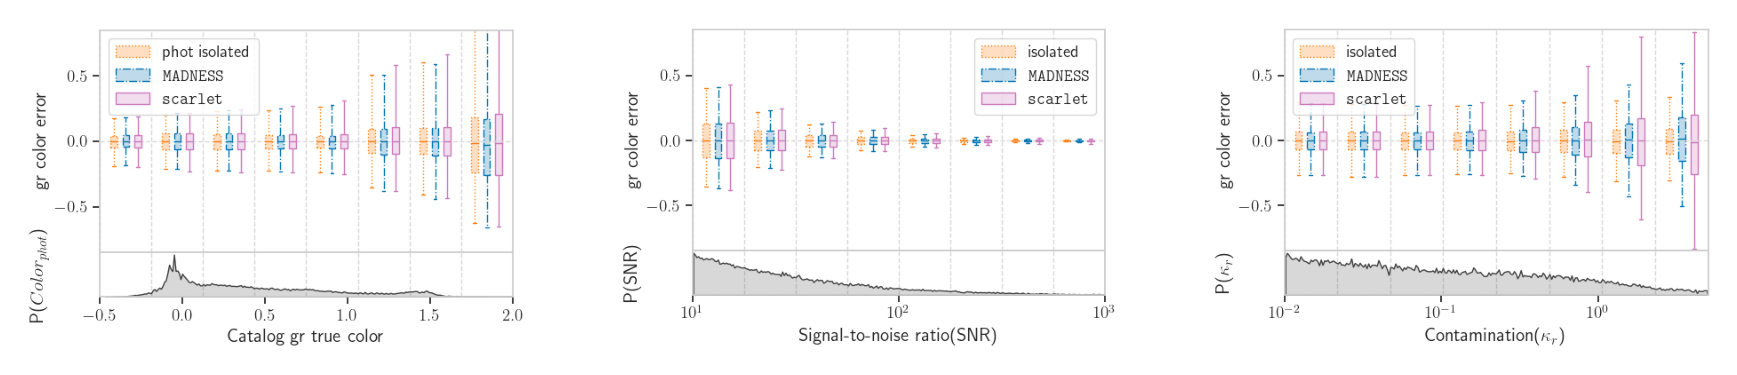

In [38]:
f, axarr = plt.subplots(1, 3, figsize=(18, 4))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ims_bias_color_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ims_snr_color_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ims_contamination_color_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", density_level + "_density", "deblender_effect_" + density_level + "_density_color_boxplot_results.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join("results", density_level + "_density", "deblender_effect_" + density_level + "_density_color_boxplot_results.png"))

plt.show()

## Repeating the same, but time replace the phot measured color on isolated galaxies with blended galaxies

### The three bars in the plot below are 
- error on phot measured color on blended galaxies
- error on deblended galaxies from madness
- error on deblended galaxies from scarlet

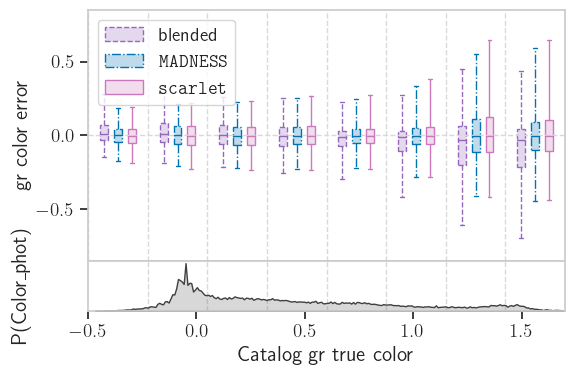

In [39]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = color_bands+"_truth", y = color_bands+'_color_err_true', z = "type",
    xlim = (-.5, 1.7),
    ylim = (-.85, 0.85),
    x_scale = None,
    legend = ['blended', madness_plot_label, scarlet_plot_label],
    x_label=f'Catalog {color_bands} true color', 
    y_label = color_bands + ' color error',
    y_label_hist=r'P(Color_{phot})',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "bms_bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp",  "bms_bias_color_box_plot.png"))

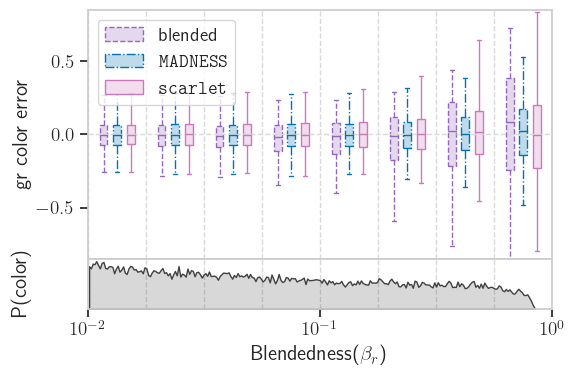

In [40]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "r_blendedness", y = color_bands + '_color_err_true', z = "type",
    xlim = (1e-2, 1),
    ylim = (-.85, 0.85),
    x_scale = 'log',
    legend = ['blended', madness_plot_label, scarlet_plot_label],
    x_label=r'Blendedness($\beta_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(color)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
    x_major_grid=True,
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "bms_blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "bms_blendedness_color_box_plot.png"))

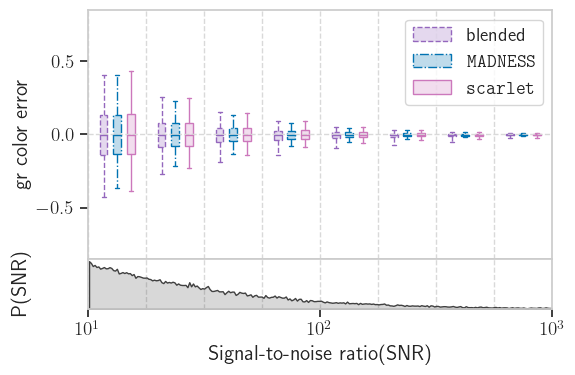

In [41]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = 'snr', y = color_bands + "_color_err_true", z = "type",
    xlim = (10, 1000),
    ylim = (-.85, 0.85), 
    x_scale = 'log',
    legend = ['blended', madness_plot_label, scarlet_plot_label],
    x_label='Signal-to-noise ratio(SNR)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(SNR)',
    legend_remove = False,
    legend_location = "upper right",
    whis = [5,95],
    percents = [25,75],
    palette = [blended_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
    x_major_grid=True,
)

plt.savefig(os.path.join("results", density_level + "_density", "temp", "bms_snr_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "bms_snr_color_box_plot.png"))

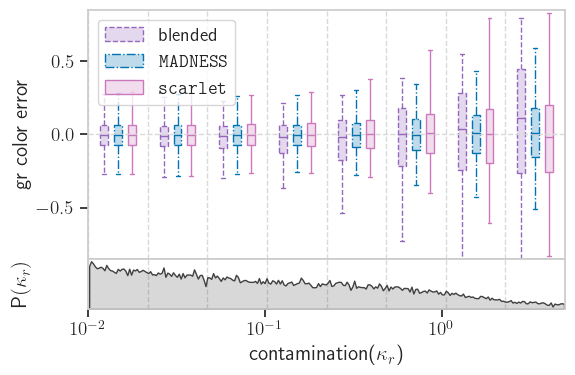

In [42]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = 'r_contamination', y = f"{color_bands}_color_err_true", z = "type",
    xlim = (1e-2, 5),
    ylim = (-.85, 0.85),
    x_scale = 'log',
    legend = ['blended', madness_plot_label, scarlet_plot_label],
    x_label=r'contamination($\kappa_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P$(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "bms_contamination_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp",  "bms_contamination_color_box_plot.png"))

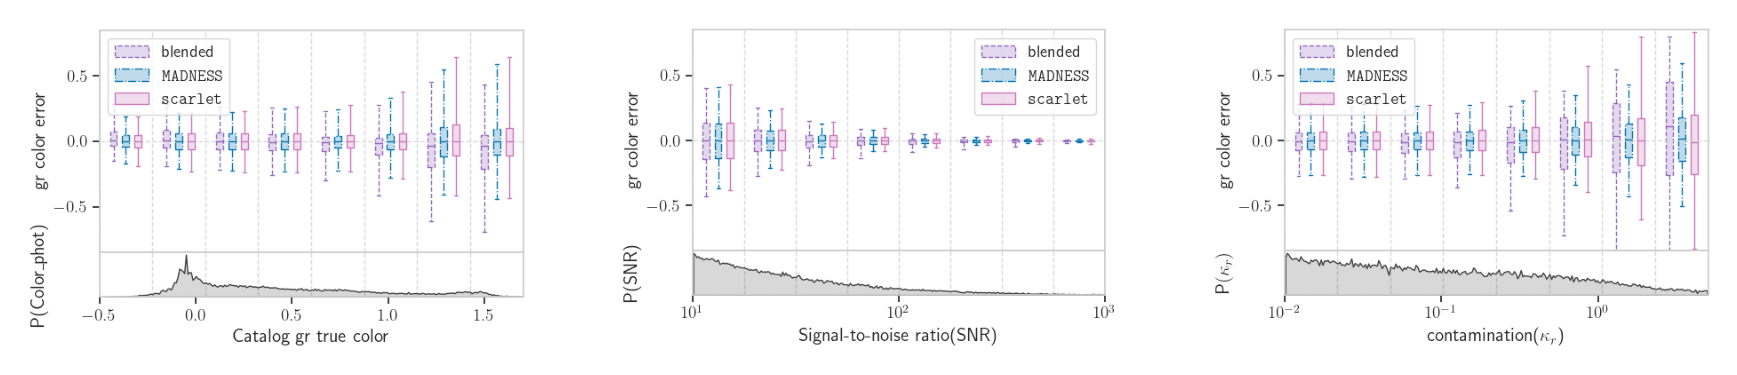

In [43]:
f, axarr = plt.subplots(1, 3, figsize=(18, 4))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "bms_bias_color_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "bms_snr_color_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "bms_contamination_color_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", density_level + "_density", density_level + "_deblender_improvement_density_color_boxplot_results.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join("results", density_level + "_density", density_level + "_deblender_improvement_density_color_boxplot_results.png"))

plt.show()

# Errors from deblender against photometry measured color
### replacing the x axis with photometry measured color on isolated galaxiesinstead of catalog truth color

In [44]:
mask=boxplot_color_df["type"].isin(['madness', 'scarlet'])

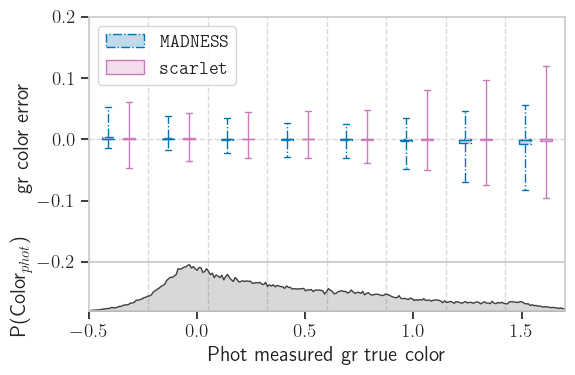

In [45]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df[mask], 
    x = color_bands+"_phot", y = color_bands + "_color_err_phot", z = "type",
    xlim = (-.5, 1.7),
    ylim = (-.2, .2), 
    x_scale = None,
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=f'Phot measured {color_bands} true color', 
    y_label = color_bands + ' color error',
    y_label_hist=r'P(Color$_{phot}$)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_bias_color_box_plot.png"), dpi=900)

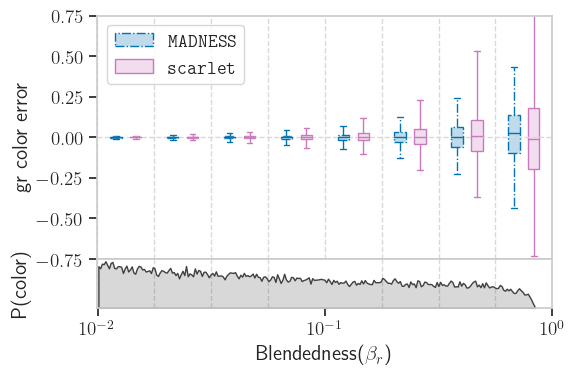

In [46]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df[mask], 
    x = "r_blendedness", y = color_bands + "_color_err_phot", z = "type",
    xlim = (1e-2, 1),
    ylim = (-.75, .75), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=r'Blendedness($\beta_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(color)',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_blendedness_color_box_plot.png"), dpi=900)

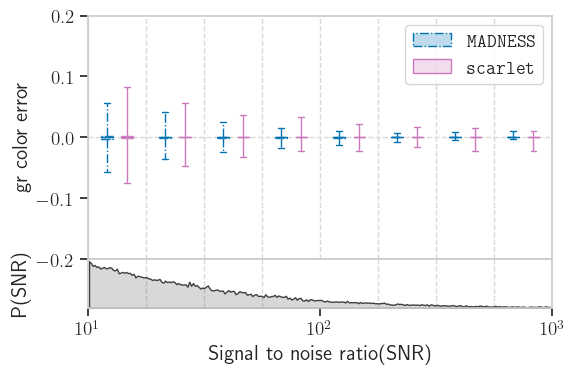

In [47]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_color_df[mask], 
    x = 'snr', y = color_bands + "_color_err_phot", z = "type",
    xlim = (10, 1000),
    ylim = (-.2, 0.2), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label='Signal to noise ratio(SNR)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P(SNR)',
    legend_remove = False,
    legend_location = "upper right",
    whis = [5,95],
    percents = [25,75],
    palette = [madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[madness_plot_ls, scarlet_plot_ls],
)

plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_snr_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_snr_color_box_plot.png"), dpi=900)

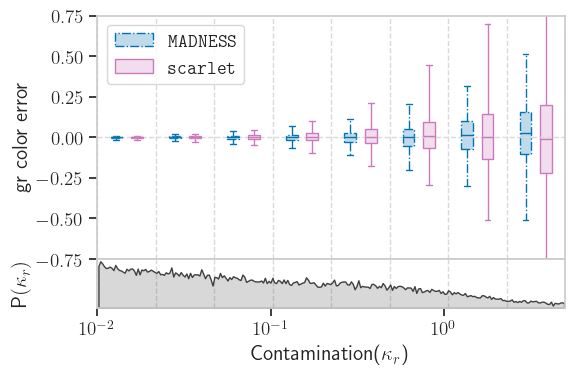

In [48]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df[mask], 
    x = 'r_contamination', y = f"{color_bands}_color_err_phot", z = "type",
    xlim = (1e-2, 5),
    ylim = (-.75, .75), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=r'Contamination($\kappa_r$)', 
    y_label = f'{color_bands} color error',
    y_label_hist=r'P$(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 8,
    ls=[madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_contamination_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "temp", "ms_contamination_color_box_plot.png"), dpi=900)

In [ ]:
f, axarr = plt.subplots(1, 3, figsize=(18, 4))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ms_bias_color_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ms_snr_color_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "temp", "ms_contamination_color_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", density_level + "_density", density_level + "_density_color_boxplot_results.pdf"), format="pdf", bbox_inches="tight", dpi=1200)
plt.savefig(os.path.join("results", density_level + "_density", density_level + "_density_color_boxplot_results.png"))

plt.show()